# Dispatch Testing

Brendan Smithyman | March 2015

In [1]:
import numpy as np
import networkx
from zephyr.Dispatcher import SeisFDFDDispatcher
from IPython.parallel import Reference
from pymatsolver import MumpsSolver
import SimPEG
import scipy.sparse

## Plotting configuration

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

## System / modelling configuration

In [3]:
cellSize    = 1             # m
freqs       = [2e2]         # Hz
density     = 2700          # units of density
Q           = 500           # can be inf
nx          = 164           # count
nz          = 264           # count
freeSurf    = [False, False, False, False] # t r b l
dims        = (nx,nz)       # tuple
nPML        = 32
rho         = np.fliplr(np.ones(dims) * density)
nfreq       = len(freqs)    # number of frequencies
nky         = 80            # number of y-directional plane-wave components
nsp         = nfreq * nky   # total number of 2D subproblems

velocity    = 2500          # m/s
vanom       = 0             # m/s
cPert       = np.zeros(dims)
cPert[(nx/2)-20:(nx/2)+20,(nz/2)-20:(nz/2)+20] = vanom
c           = np.fliplr(np.ones(dims) * velocity)
cFlat       = c
c          += np.fliplr(cPert)
cTrue       = c

srcs        = np.array([np.ones(101)*32, np.zeros(101), np.linspace(32, 232, 101)]).T
recs        = np.array([np.ones(101)*132, np.zeros(101), np.linspace(32, 232, 101)]).T
nsrc        = len(srcs)
nrec        = len(recs)
recmode     = 'fixed'

geom        = {
    'src':  srcs,
    'rec':  recs,
    'mode': 'fixed',
}

cache       = False
cacheDir    = '.'

parFac = 2
chunksPerWorker = 0.5       # NB: parFac * chunksPerWorker = number of source array subsets
ensembleClear = False

profile = 'phobos'

# Base configuration for all subproblems
systemConfig = {
    'dx':   cellSize,       # m
    'dz':   cellSize,       # m
    'c':        c.T,        # m/s
    'rho':      rho.T,      # density
    'Q':        Q,          # can be inf
    'nx':       nx,         # count
    'nz':       nz,         # count
    'freeSurf': freeSurf,   # t r b l
    'nPML':     nPML,
    'geom':     geom,
    'cache':    cache,
    'cacheDir': cacheDir,
    'freqs':    freqs,
    'nky':      nky,
    'parFac':   parFac,
    'chunksPerWorker':  chunksPerWorker,
    'profile':  profile,
    'ensembleClear':    ensembleClear,
#     'MPI': False,
#    'Solver':   Reference('SimPEG.SolverWrapD(scipy.sparse.linalg.splu)'),#Solver,
}

In [4]:
%%time
sp = SeisFDFDDispatcher(systemConfig)
survey, problem = sp.spawnInterfaces()
txs = survey.genTx()
sp.txs = txs

CPU times: user 1.89 s, sys: 344 ms, total: 2.24 s
Wall time: 21 s


In [5]:
%%time
d = survey.projectFields()

CPU times: user 42.2 s, sys: 11.1 s, total: 53.3 s
Wall time: 4min 51s


In [6]:
%%time
uF = problem.fields()

CPU times: user 7.01 s, sys: 1.95 s, total: 8.96 s
Wall time: 50.8 s


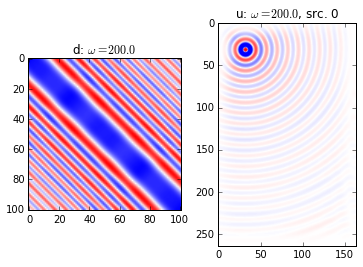

In [7]:
freqNum = 0
srcNum = 0

frt = uF[freqNum]
drt = d[freqNum]
frt.shape = (nsrc, nz, nx)
clipScale = 1e-1 * abs(frt[srcNum]).max()

fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
plt.imshow(drt.real, cmap=cm.bwr)
plt.title('d: $\omega = %0.1f$'%(freqs[freqNum],))

ax2 = fig.add_subplot(1,2,2)
plt.imshow(frt[srcNum].real, vmin=-clipScale, vmax=clipScale, cmap=cm.bwr)
plt.title('u: $\omega = %0.1f$, src. %d'%(freqs[freqNum], srcNum))